## Installs and Imports

In [93]:
!pip install tensorflow -q
!pip install tf-keras -q

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Model


# Descargar archivos

In [95]:
from google.colab import drive
drive.mount('/content/drive')

DRIVE_PATH = "/content/drive/MyDrive/Semestre 7/Colabs/Benji/Move Predictor/"

df = pd.read_csv(DRIVE_PATH + "pokemon_teams_and_leads.csv")

with open(DRIVE_PATH + "encoder.pkl", "rb") as f:
    encoder = pickle.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [96]:
df.head()

,j1_1,j1_2,j1_3,j1_4,j1_5,j1_6,j2_1,j2_2,j2_3,j2_4,j2_5,j2_6,j1_l1,j1_l2,j2_l1,j2_l2
0,56,406,462,508,530,573,236,286,388,406,495,551,508,531,236,495
1,9,144,226,262,286,524,56,285,306,331,462,501,9,262,331,462
2,200,206,209,280,286,388,9,56,236,343,406,495,200,209,56,343
3,56,206,236,269,345,495,9,144,226,262,286,524,56,345,226,262
4,9,56,67,321,388,508,9,56,161,198,236,263,67,321,236,263


In [97]:
print("TensorFlow version:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

TensorFlow version: 2.19.0
GPU disponible: []


In [98]:
INPUT_COLS = ["j1_1","j1_2","j1_3","j1_4","j1_5","j1_6",
              "j2_1","j2_2","j2_3","j2_4","j2_5","j2_6",]
LABEL_COLS = ["j2_l1","j2_l2"]

for col in INPUT_COLS + LABEL_COLS:
    if col not in df.columns:
        raise ValueError(f"Falta la columna: {col}")

X = df[INPUT_COLS].to_numpy()
print(X.shape)
Y = df[LABEL_COLS].to_numpy()
print(Y.shape)

(4935, 12)
(4935, 2)


# Data split

In [99]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

Y_train = [Y_train[:,0], Y_train[:,1]]
Y_val = [Y_val[:,0], Y_val[:,1]]
Y_test = [Y_test[:,0], Y_test[:,1]]

# Primer Modelo

## Construcción

In [100]:
VOCABULARY = np.max(X) + 1
EMBEDDING_DIM = 16
SEQUENCE_LEN = len(INPUT_COLS)

print(VOCABULARY)
print(EMBEDDING_DIM)
print(SEQUENCE_LEN)

584
16
12


In [101]:
inputs = layers.Input(shape=(SEQUENCE_LEN,))
embedding_layer = layers.Embedding(input_dim=VOCABULARY, output_dim=EMBEDDING_DIM)
result = embedding_layer(inputs)

print(result.shape)

(None, 12, 16)


In [102]:
flatten_layer = layers.Flatten()
result = flatten_layer(result)
print(result.shape)

(None, 192)


In [103]:
dense_layer = layers.Dense(64, activation="relu")
result = dense_layer(result)
print(result.shape)

(None, 64)


In [104]:
softmax_layer1 = layers.Dense(VOCABULARY, activation="softmax", name="lead1")
softmax_layer2 = layers.Dense(VOCABULARY, activation="softmax", name="lead2")
output1 = softmax_layer1(result)
output2 = softmax_layer2(result)

In [105]:
model = Model(inputs=inputs, outputs=[output1,output2])
model.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_20        │ (None, 12, 16)    │      9,344 │ input_layer_20[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_18          │ (None, 192)       │          0 │ embedding_20[0][… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 64)        │     12,352 │ flatten_18[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead1 (Dense)       │ (None, 584)       │     37,960 │ dense_56[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lead2 (Dense)       │ (None, 584)       │     37,960 │ dense_56[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 97,616 (381.31 KB)

 Trainable params: 97,616 (381.31 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy", "accuracy"])

## Entrenamiento

In [107]:
history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=60, verbose=0)
print("Entrenamiento listo")

Entrenamiento listo


## Visualizacion

In [108]:
train_acc1 = history.history['lead1_accuracy']
val_acc1 = history.history['val_lead1_accuracy']
train_acc2 = history.history['lead2_accuracy']
val_acc2 = history.history['val_lead2_accuracy']
results = model.evaluate(X_test, Y_test, verbose=1)
test_acc1 = results[3]
test_acc2 = results[4]


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lead1_accuracy: 0.3680 - lead1_loss: 4.6835 - lead2_accuracy: 0.3516 - lead2_loss: 4.8275 - loss: 9.5039


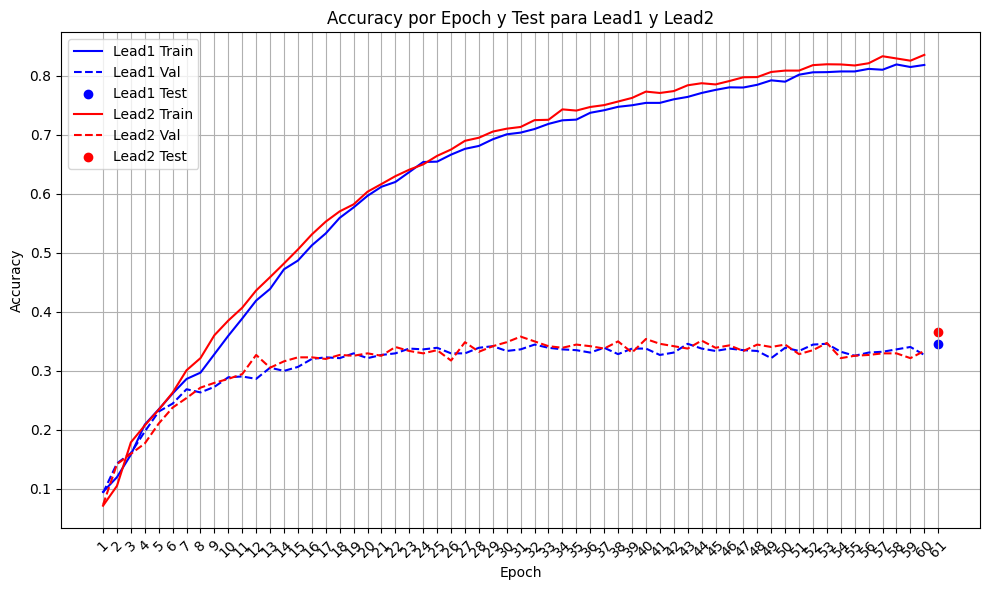

In [109]:
import matplotlib.pyplot as plt

epochs = range(1, len(train_acc1) + 1)

plt.figure(figsize=(10,6))

# Lead 1
plt.plot(epochs, train_acc1, 'b-', label='Lead1 Train')
plt.plot(epochs, val_acc1, 'b--', label='Lead1 Val')
plt.scatter(len(epochs)+1, test_acc1, color='b', marker='o', label='Lead1 Test')

# Lead 2
plt.plot(epochs, train_acc2, 'r-', label='Lead2 Train')
plt.plot(epochs, val_acc2, 'r--', label='Lead2 Val')
plt.scatter(len(epochs)+1, test_acc2, color='r', marker='o', label='Lead2 Test')

plt.title('Accuracy por Epoch y Test para Lead1 y Lead2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(epochs) + [len(epochs)+1], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Hipotesis del modelo 1

In [110]:
predictions_train = model.predict(X_train)
predictions_val = model.predict(X_val)
predictions_test = model.predict(X_test)

lead1_train = np.argmax(predictions_train[0], axis=1)
lead2_train = np.argmax(predictions_train[1], axis=1)

lead1_val = np.argmax(predictions_val[0], axis=1)
lead2_val = np.argmax(predictions_val[1], axis=1)

lead1_test = np.argmax(predictions_test[0], axis=1)
lead2_test = np.argmax(predictions_test[1], axis=1)

108/108 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [111]:
df_train = pd.DataFrame(X_train, columns=INPUT_COLS)
df_train["pred_lead1"] = lead1_train
df_train["pred_lead2"] = lead2_train

df_val = pd.DataFrame(X_val, columns=INPUT_COLS)
df_val["pred_lead1"] = lead1_val
df_val["pred_lead2"] = lead2_val

df_test = pd.DataFrame(X_test, columns=INPUT_COLS)
df_test["pred_lead1"] = lead1_test
df_test["pred_lead2"] = lead2_test

## Checamos las veces que no se encuntra la prediccion en los inputs

In [112]:
df_train["has_lead1"] = df_train.drop("pred_lead1", axis=1).isin(df_train["pred_lead1"]).any(axis=1)
df_train["has_lead2"] = df_train.drop("pred_lead2", axis=1).isin(df_train["pred_lead2"]).any(axis=1)
print("Porcentaje de encontrado en train:", (df_train["has_lead1"].value_counts()/len(df_train)))
print("Porcentaje de encontrado en train:", (df_train["has_lead2"].value_counts()/len(df_train)))
print()
df_val["has_lead1"] = df_val.drop("pred_lead1", axis=1).isin(df_val["pred_lead1"]).any(axis=1)
df_val["has_lead2"] = df_val.drop("pred_lead2", axis=1).isin(df_val["pred_lead2"]).any(axis=1)
print("Porcentaje de encontrado en val:", (df_val["has_lead1"].value_counts()/len(df_val)))
print("Porcentaje de encontrado en val:", (df_val["has_lead2"].value_counts()/len(df_val)))
print()
df_test["has_lead1"] = df_test.drop("pred_lead1", axis=1).isin(df_test["pred_lead1"]).any(axis=1)
df_test["has_lead2"] = df_test.drop("pred_lead2", axis=1).isin(df_test["pred_lead2"]).any(axis=1)
print("Porcentaje de encontrado en test:", (df_test["has_lead1"].value_counts()/len(df_test)))
print("Porcentaje de encontrado en test:", (df_test["has_lead2"].value_counts()/len(df_test)))

Porcentaje de encontrado en train: has_lead1
True     0.989867
False    0.010133
Name: count, dtype: float64
Porcentaje de encontrado en train: has_lead2
True     0.886798
False    0.113202
Name: count, dtype: float64

Porcentaje de encontrado en val: has_lead1
True     0.910811
False    0.089189
Name: count, dtype: float64
Porcentaje de encontrado en val: has_lead2
True     0.760811
False    0.239189
Name: count, dtype: float64

Porcentaje de encontrado en test: has_lead1
True     0.904184
False    0.095816
Name: count, dtype: float64
Porcentaje de encontrado en test: has_lead2
True     0.785425
False    0.214575
Name: count, dtype: float64


Conclusion rapida, tal parece que no esta aprendiendo bien a elegir el lead2, esta eligiendo pokemones que no estan presente en el la secuencia, es necesario agreagar eso al los porque casi el 20% de las veces ni esta el pokemon (NO podemos simplente ponerle una condicion para que depues del softmax solo eliga los que estan presente, la razon princiapal seria que no estra aprendiendo y nunc aprendera si no hay un loss para elegir un pokemon fuera de eso.

## Checamos si repiten pokemons

In [113]:
df_train["same lead"] = df_train["pred_lead1"] == df_train["pred_lead2"]
print("Porcentaje de repeticion en train:", (df_train["same lead"].value_counts()/len(df_train)))
print()
df_val["same lead"] = df_val["pred_lead1"] == df_val["pred_lead2"]
print("Porcentaje de repeticion en val:", (df_val["same lead"].value_counts()/len(df_val)))
print()
df_test["same lead"] = df_test["pred_lead1"] == df_test["pred_lead2"]
print("Porcentaje de repeticion en test:", (df_test["same lead"].value_counts()/len(df_test)))

Porcentaje de repeticion en train: same lead
False    0.980892
True     0.019108
Name: count, dtype: float64

Porcentaje de repeticion en val: same lead
False    0.932432
True     0.067568
Name: count, dtype: float64

Porcentaje de repeticion en test: same lead
False    0.950067
True     0.049933
Name: count, dtype: float64


Parece que esto no es un problema, pero puede mejorar, porque el 5% porciento de las veces esta haciendo algo que no es puede que es elegir el mismo pokemon.

# Modelo 2

Le vamos a agregar más capas sin setnido hasta que algo pegue antes de metenernos con el loss

In [114]:
VOCABULARY = np.max(X) + 1
EMBEDDING_DIM = 16
SEQUENCE_LEN = len(INPUT_COLS)

inputs = layers.Input(shape=(SEQUENCE_LEN,))
embedding_layer = layers.Embedding(input_dim=VOCABULARY, output_dim=EMBEDDING_DIM)
result = embedding_layer(inputs)

flatten_layer = layers.Flatten()
result = flatten_layer(result)

result = layers.Dense(64, activation="relu")(result)
result = layers.Dense(64, activation="relu")(result)



softmax_layer1 = layers.Dense(VOCABULARY, activation="softmax", name="lead1")
softmax_layer2 = layers.Dense(VOCABULARY, activation="softmax", name="lead2")
output1 = softmax_layer1(result)
output2 = softmax_layer2(result)

model = Model(inputs=inputs, outputs=[output1,output2])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy", "accuracy"])

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, verbose=0)
print("Entrenamiento listo")

Entrenamiento listo


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lead1_accuracy: 0.3329 - lead1_loss: 7.3484 - lead2_accuracy: 0.3697 - lead2_loss: 6.8928 - loss: 14.2406


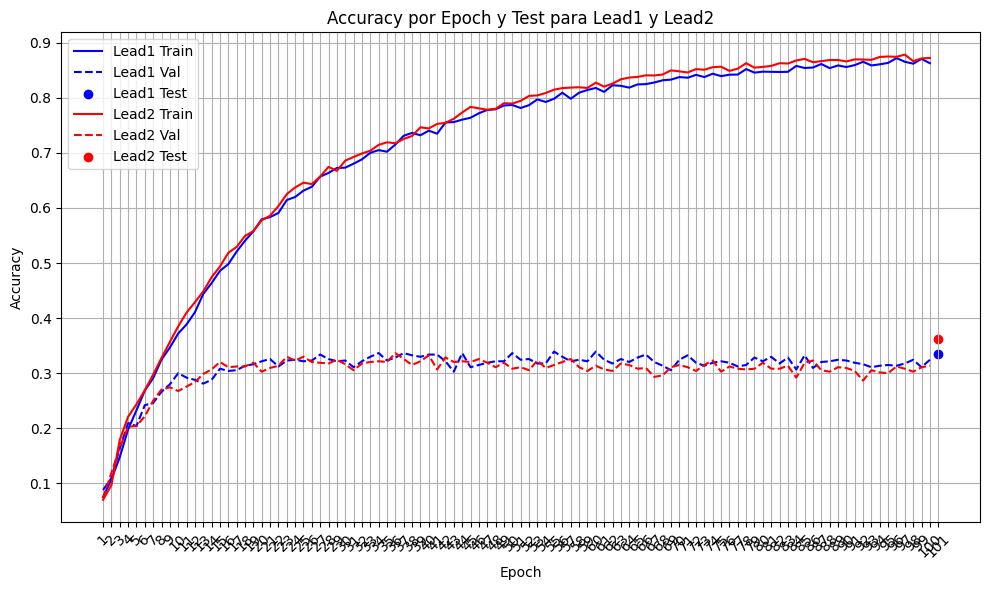

In [115]:
train_acc1 = history.history['lead1_accuracy']
val_acc1 = history.history['val_lead1_accuracy']
train_acc2 = history.history['lead2_accuracy']
val_acc2 = history.history['val_lead2_accuracy']
results = model.evaluate(X_test, Y_test, verbose=1)
test_acc1 = results[3]
test_acc2 = results[4]

import matplotlib.pyplot as plt

epochs = range(1, len(train_acc1) + 1)

plt.figure(figsize=(10,6))

# Lead 1
plt.plot(epochs, train_acc1, 'b-', label='Lead1 Train')
plt.plot(epochs, val_acc1, 'b--', label='Lead1 Val')
plt.scatter(len(epochs)+1, test_acc1, color='b', marker='o', label='Lead1 Test')

# Lead 2
plt.plot(epochs, train_acc2, 'r-', label='Lead2 Train')
plt.plot(epochs, val_acc2, 'r--', label='Lead2 Val')
plt.scatter(len(epochs)+1, test_acc2, color='r', marker='o', label='Lead2 Test')

plt.title('Accuracy por Epoch y Test para Lead1 y Lead2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(epochs) + [len(epochs)+1], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [116]:
print("Train accuracy lead1", train_acc1[-1])
print("Val accuracy lead1", val_acc1[-1])
print("Test accuracy lead1", test_acc1)
print()
print("Train accuracy lead2", train_acc2[-1])
print("Val accuracy lead2", val_acc2[-1])
print("Test accuracy lead2", test_acc2)

Train accuracy lead1 0.8627678155899048
Val accuracy lead1 0.3243243098258972
Test accuracy lead1 0.3346828520298004

Train accuracy lead2 0.8723219633102417
Val accuracy lead2 0.31351351737976074
Test accuracy lead2 0.36167341470718384


Ni modod pues no es el modelo, es el data set toco hacer data aumentation

## Modelo 2.2

In [177]:
VOCABULARY = np.max(X) + 1
EMBEDDING_DIM = 8
SEQUENCE_LEN = len(INPUT_COLS)

inputs = layers.Input(shape=(SEQUENCE_LEN,))
embedding_layer = layers.Embedding(input_dim=VOCABULARY, output_dim=EMBEDDING_DIM)
result = embedding_layer(inputs)

flatten_layer = layers.Flatten()
result = flatten_layer(result)

result = layers.Dense(8, activation="relu")(result)
result = layers.Dense(16, activation="relu")(result)
result = layers.Dropout(0.1)(result)


softmax_layer1 = layers.Dense(VOCABULARY, activation="softmax", name="lead1")
softmax_layer2 = layers.Dense(VOCABULARY, activation="softmax", name="lead2")
output1 = softmax_layer1(result)
output2 = softmax_layer2(result)

model = Model(inputs=inputs, outputs=[output1,output2])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy", "accuracy"])

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=300, verbose=0)
print("Entrenamiento listo")

Entrenamiento listo


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lead1_accuracy: 0.2998 - lead1_loss: 8.2038 - lead2_accuracy: 0.3217 - lead2_loss: 8.4801 - loss: 16.6907


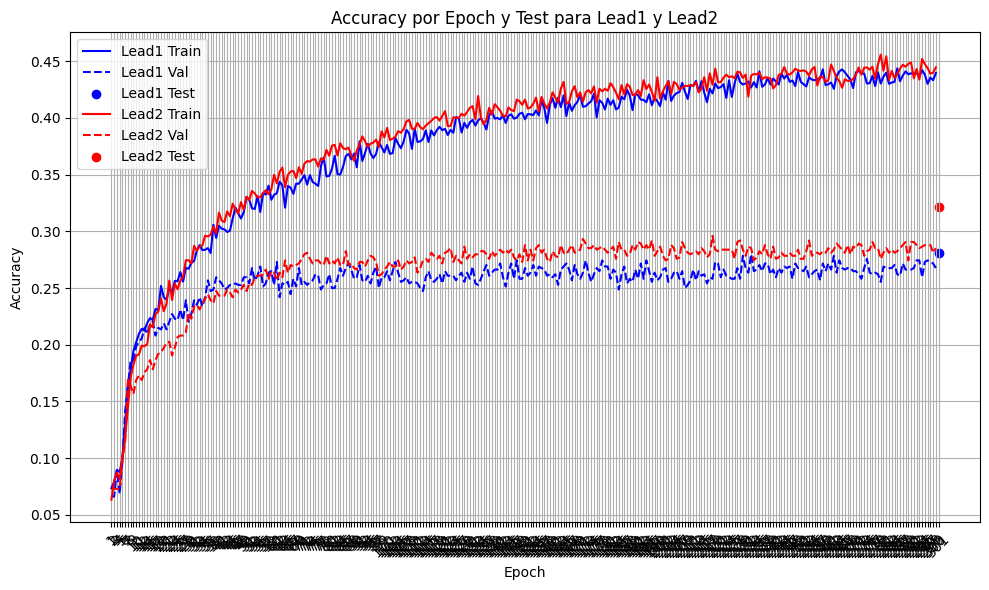

In [178]:
train_acc1 = history.history['lead1_accuracy']
val_acc1 = history.history['val_lead1_accuracy']
train_acc2 = history.history['lead2_accuracy']
val_acc2 = history.history['val_lead2_accuracy']
results = model.evaluate(X_test, Y_test, verbose=1)
test_acc1 = results[3]
test_acc2 = results[4]

import matplotlib.pyplot as plt

epochs = range(1, len(train_acc1) + 1)

plt.figure(figsize=(10,6))

# Lead 1
plt.plot(epochs, train_acc1, 'b-', label='Lead1 Train')
plt.plot(epochs, val_acc1, 'b--', label='Lead1 Val')
plt.scatter(len(epochs)+1, test_acc1, color='b', marker='o', label='Lead1 Test')

# Lead 2
plt.plot(epochs, train_acc2, 'r-', label='Lead2 Train')
plt.plot(epochs, val_acc2, 'r--', label='Lead2 Val')
plt.scatter(len(epochs)+1, test_acc2, color='r', marker='o', label='Lead2 Test')

plt.title('Accuracy por Epoch y Test para Lead1 y Lead2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(epochs) + [len(epochs)+1], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [179]:
print("Train accuracy lead1", train_acc1[-1])
print("Val accuracy lead1", val_acc1[-1])
print("Test accuracy lead1", test_acc1)
print()
print("Train accuracy lead2", train_acc2[-1])
print("Val accuracy lead2", val_acc2[-1])
print("Test accuracy lead2", test_acc2)

Train accuracy lead1 0.4394904375076294
Val accuracy lead1 0.26756757497787476
Test accuracy lead1 0.28070175647735596

Train accuracy lead2 0.4444122612476349
Val accuracy lead2 0.2851351499557495
Test accuracy lead2 0.3211875855922699


# Modelo 3

In [ ]:
Y_train

[array([ 34,  50, 286, ..., 286, 161,  35]),
 array([561,  56, 389, ..., 321, 263, 361])]

In [ ]:
Y_train[0].shape


(3454,)

In [ ]:
ROTATIONS = 6

In [ ]:
def augment_Y(Y, n_rotations=3):
    """
    Duplica Y tantas veces como rotaciones se hicieron en X.

    Y: np.array, shape (n_samples,) o (n_samples, 1)
    n_rotations: cuántas rotaciones se aplicaron a X
    """
    Y = Y.reshape(-1, 1)  # aseguramos que sea 2D
    Y_aug = Y.copy()
    for _ in range(n_rotations):
        Y_aug = np.vstack([Y_aug, Y.copy()])
    return Y_aug

# Uso
Y_lead1_aug = augment_Y(Y_train[0], n_rotations=ROTATIONS)
Y_lead1_aug.reshape((-1,))
Y_lead2_aug = augment_Y(Y_train[1], n_rotations=ROTATIONS)
Y_lead2_aug.reshape((-1,))
print("Nuevo tamaño Y_lead1_aug:", Y_lead1_aug.shape)
print("Nuevo tamaño Y_lead2_aug:", Y_lead2_aug.shape)
Y_train_aug = [Y_lead1_aug, Y_lead2_aug]


Nuevo tamaño Y_lead1_aug: (24178, 1)
Nuevo tamaño Y_lead2_aug: (24178, 1)


In [ ]:
import numpy as np

def rotate_team(team, shift):
    """Rota un equipo de 6 Pokémon a la derecha `shift` posiciones."""
    return np.roll(team, shift)

def augment_X_teams(X, n_rotations=3):
    """
    Hace data augmentation rotando los equipos por separado.

    X: np.array, shape (n_samples, 12)
    n_rotations: cuántas rotaciones generar
    """
    X_aug = X.copy()  # empezamos con los datos originales

    for shift in range(1, n_rotations + 1):
        X_rot = []
        for row in X:
            # separar equipos
            team1 = row[:6]
            team2 = row[6:]
            # rotar cada equipo
            team1_rot = rotate_team(team1, shift)
            team2_rot = rotate_team(team2, shift)
            # unir de nuevo
            X_rot.append(np.concatenate([team1_rot, team2_rot]))
        X_rot = np.array(X_rot)
        # agregar al dataset
        X_aug = np.vstack([X_aug, X_rot])

    return X_aug

# Ejemplo de uso
X_train_aug = augment_X_teams(X_train, n_rotations=ROTATIONS)
print("Tamaño original X_train:", X_train.shape)
print("Tamaño X_train después de rotaciones:", X_train_aug.shape)


Tamaño original X_train: (3454, 12)
Tamaño X_train después de rotaciones: (24178, 12)


In [ ]:
VOCABULARY = np.max(X) + 1
EMBEDDING_DIM = 11
SEQUENCE_LEN = len(INPUT_COLS)

inputs = layers.Input(shape=(SEQUENCE_LEN,))
embedding_layer = layers.Embedding(input_dim=VOCABULARY, output_dim=EMBEDDING_DIM)
result = embedding_layer(inputs)

flatten_layer = layers.Flatten()
result = flatten_layer(result)

result = layers.Dense(64, activation="relu")(result)
result = layers.Dropout(0.1)(result)
result = layers.Dense(64, activation="relu")(result)
result = layers.Dropout(0.2)(result)


softmax_layer1 = layers.Dense(VOCABULARY, activation="softmax", name="lead1")
softmax_layer2 = layers.Dense(VOCABULARY, activation="softmax", name="lead2")
output1 = softmax_layer1(result)
output2 = softmax_layer2(result)

model = Model(inputs=inputs, outputs=[output1,output2])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy", "accuracy"])

history = model.fit(X_train_aug, Y_train_aug, validation_data=(X_val, Y_val), epochs=100, verbose=0)
print("Entrenamiento listo")

Entrenamiento listo


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lead1_accuracy: 0.3598 - lead1_loss: 8.2806 - lead2_accuracy: 0.3710 - lead2_loss: 8.2877 - loss: 16.5735


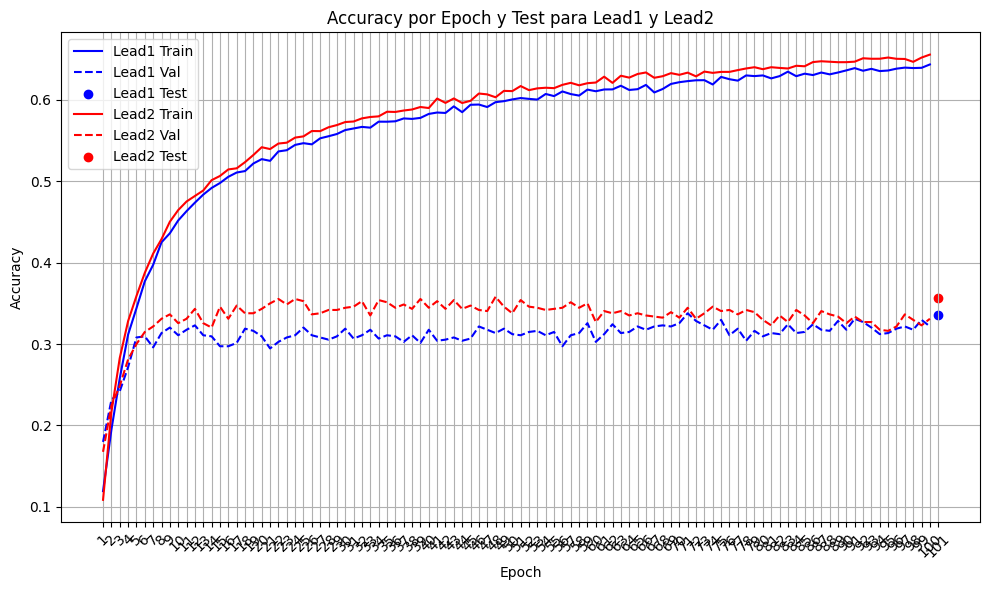

In [ ]:
train_acc1 = history.history['lead1_accuracy']
val_acc1 = history.history['val_lead1_accuracy']
train_acc2 = history.history['lead2_accuracy']
val_acc2 = history.history['val_lead2_accuracy']
results = model.evaluate(X_test, Y_test, verbose=1)
test_acc1 = results[3]
test_acc2 = results[4]

import matplotlib.pyplot as plt

epochs = range(1, len(train_acc1) + 1)

plt.figure(figsize=(10,6))

# Lead 1
plt.plot(epochs, train_acc1, 'b-', label='Lead1 Train')
plt.plot(epochs, val_acc1, 'b--', label='Lead1 Val')
plt.scatter(len(epochs)+1, test_acc1, color='b', marker='o', label='Lead1 Test')

# Lead 2
plt.plot(epochs, train_acc2, 'r-', label='Lead2 Train')
plt.plot(epochs, val_acc2, 'r--', label='Lead2 Val')
plt.scatter(len(epochs)+1, test_acc2, color='r', marker='o', label='Lead2 Test')

plt.title('Accuracy por Epoch y Test para Lead1 y Lead2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(epochs) + [len(epochs)+1], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("Train accuracy lead1", train_acc1[-1])
print("Val accuracy lead1", val_acc1[-1])
print("Test accuracy lead1", test_acc1)
print()
print("Train accuracy lead2", train_acc2[-1])
print("Val accuracy lead2", val_acc2[-1])
print("Test accuracy lead2", test_acc2)

Train accuracy lead1 0.6436015963554382
Val accuracy lead1 0.3216216266155243
Test accuracy lead1 0.3360323905944824

Train accuracy lead2 0.655720055103302
Val accuracy lead2 0.3310810923576355
Test accuracy lead2 0.3562752902507782


# Modelo 4

toca cambiar la metrica de accurarcy

In [174]:
from tensorflow.keras import backend as K
from tensorflow.keras import metrics


def top3_lead1(y_true, y_pred):
    return metrics.sparse_top_k_categorical_accuracy(y_true, y_pred, k=3)

def top3_lead2(y_true, y_pred):
    return metrics.sparse_top_k_categorical_accuracy(y_true, y_pred, k=3)

VOCABULARY = np.max(X) + 1
EMBEDDING_DIM = 8
SEQUENCE_LEN = len(INPUT_COLS)

inputs = layers.Input(shape=(SEQUENCE_LEN,))
embedding_layer = layers.Embedding(input_dim=VOCABULARY, output_dim=EMBEDDING_DIM)
result = embedding_layer(inputs)

flatten_layer = layers.Flatten()
result = flatten_layer(result)

result = layers.Dense(8, activation="relu")(result)
result = layers.Dense(16, activation="relu")(result)
result = layers.Dropout(0.1)(result)
#result = layers.Dense(64, activation="relu")(result)
#result = layers.Dense(64, activation="relu")(result)
#result = layers.Dropout(0.5)(result)
#result = layers.Dense(64, activation="relu")(result)
#result = layers.Dropout(0.5)(result)

softmax_layer1 = layers.Dense(VOCABULARY, activation="softmax", name="lead1")
softmax_layer2 = layers.Dense(VOCABULARY, activation="softmax", name="lead2")
output1 = softmax_layer1(result)
output2 = softmax_layer2(result)

model = Model(inputs=inputs, outputs=[output1,output2])

model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=[top3_lead1, top3_lead2]
)

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, verbose=0)
print("Entrenamiento listo")

Entrenamiento listo


24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - lead1_loss: 4.5120 - lead1_top3_lead1: 0.5545 - lead2_loss: 4.6006 - lead2_top3_lead2: 0.5435 - loss: 9.1204


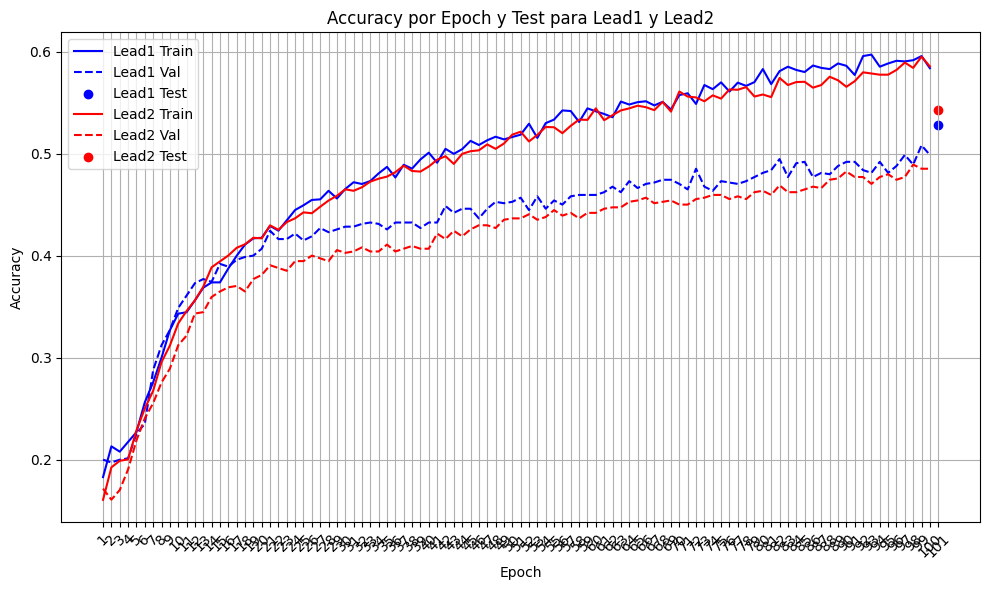

In [175]:
train_acc1 = history.history['lead1_top3_lead1']
val_acc1 = history.history['val_lead1_top3_lead1']
train_acc2 = history.history['lead2_top3_lead2']
val_acc2 = history.history['val_lead2_top3_lead2']
results = model.evaluate(X_test, Y_test, verbose=1)
test_acc1 = results[3]
test_acc2 = results[4]

import matplotlib.pyplot as plt

epochs = range(1, len(train_acc1) + 1)

plt.figure(figsize=(10,6))

# Lead 1
plt.plot(epochs, train_acc1, 'b-', label='Lead1 Train')
plt.plot(epochs, val_acc1, 'b--', label='Lead1 Val')
plt.scatter(len(epochs)+1, test_acc1, color='b', marker='o', label='Lead1 Test')

# Lead 2
plt.plot(epochs, train_acc2, 'r-', label='Lead2 Train')
plt.plot(epochs, val_acc2, 'r--', label='Lead2 Val')
plt.scatter(len(epochs)+1, test_acc2, color='r', marker='o', label='Lead2 Test')

plt.title('Accuracy por Epoch y Test para Lead1 y Lead2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(epochs) + [len(epochs)+1], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [176]:
print("Train accuracy lead1", train_acc1[-1])
print("Val accuracy lead1", val_acc1[-1])
print("Test accuracy lead1", test_acc1)
print()
print("Train accuracy lead2", train_acc2[-1])
print("Val accuracy lead2", val_acc2[-1])
print("Test accuracy lead2", test_acc2)

Train accuracy lead1 0.5836710929870605
Val accuracy lead1 0.49864864349365234
Test accuracy lead1 0.5276653170585632

Train accuracy lead2 0.5854082107543945
Val accuracy lead2 0.48513513803482056
Test accuracy lead2 0.5425100922584534


# Mejora del dataset

In [6]:
df2 = pd.read_csv(DRIVE_PATH + "vgc_encoded.csv")
with open(DRIVE_PATH + "encoder2.pkl", "rb") as f:
    encoder2 = pickle.load(f)

df2.head()

/usr/local/lib/python3.12/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.7.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


,j1_1,j1_2,j1_3,j1_4,j1_5,j1_6,j2_1,j2_2,j2_3,j2_4,...,j2_5_def,j2_5_spa,j2_5_spd,j2_5_spe,j2_6_hp,j2_6_atk,j2_6_def,j2_6_spa,j2_6_spd,j2_6_spe
0,235,286,389,407,499,554,54,235,345,389,...,90.0,60.0,70.0,85.0,92.0,120.0,140.0,80.0,140.0,128.0
1,235,286,389,407,499,554,54,235,345,389,...,90.0,60.0,70.0,85.0,92.0,120.0,140.0,80.0,140.0,128.0
2,48,54,68,237,263,564,203,235,286,322,...,105.0,45.0,80.0,50.0,100.0,130.0,100.0,63.0,60.0,97.0
3,48,54,68,237,263,564,203,235,286,322,...,105.0,45.0,80.0,50.0,100.0,130.0,100.0,63.0,60.0,97.0
4,48,54,68,237,263,564,203,235,286,322,...,105.0,45.0,80.0,50.0,100.0,130.0,100.0,63.0,60.0,97.0


In [17]:
LABEL_COLS = ["j2_l1","j2_l2"]

INPUT_COLS = df2.columns.drop(LABEL_COLS).tolist()

for col in INPUT_COLS + LABEL_COLS:
    if col not in df2.columns:
        raise ValueError(f"Falta la columna: {col}")

X = df2[INPUT_COLS].to_numpy()
X = X.astype(int)
print(X.shape)
Y = df2[LABEL_COLS].to_numpy()
print(Y.shape)

(4761, 86)
(4761, 2)


In [18]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=42)
X_val, X_test, Y_val, Y_test = train_test_split(X_test, Y_test, test_size=0.5, random_state=42)

Y_train = [Y_train[:,0], Y_train[:,1]]
Y_val = [Y_val[:,0], Y_val[:,1]]
Y_test = [Y_test[:,0], Y_test[:,1]]

# Modelo 1.2

In [19]:
print(len(INPUT_COLS))

86


In [39]:
VOCABULARY = np.max(X) + 1
EMBEDDING_DIM = 64
SEQUENCE_LEN = len(INPUT_COLS)

inputs = layers.Input(shape=(SEQUENCE_LEN,))
embedding_layer = layers.Embedding(input_dim=VOCABULARY, output_dim=EMBEDDING_DIM)
result = embedding_layer(inputs)

flatten_layer = layers.Flatten()
result = flatten_layer(result)

result = layers.Dense(64, activation="relu")(result)
result = layers.Dropout(0.1)(result)
result = layers.Dense(64, activation="relu")(result)
result = layers.Dropout(0.2)(result)

softmax_layer1 = layers.Dense(VOCABULARY, activation="softmax", name="lead1")
softmax_layer2 = layers.Dense(VOCABULARY, activation="softmax", name="lead2")
output1 = softmax_layer1(result)
output2 = softmax_layer2(result)

model = Model(inputs=inputs, outputs=[output1,output2])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy", "accuracy"])

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, verbose=0)
print("Entrenamiento listo")

Entrenamiento listo


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - lead1_accuracy: 0.3683 - lead1_loss: 6.1879 - lead2_accuracy: 0.3278 - lead2_loss: 6.6912 - loss: 12.8769


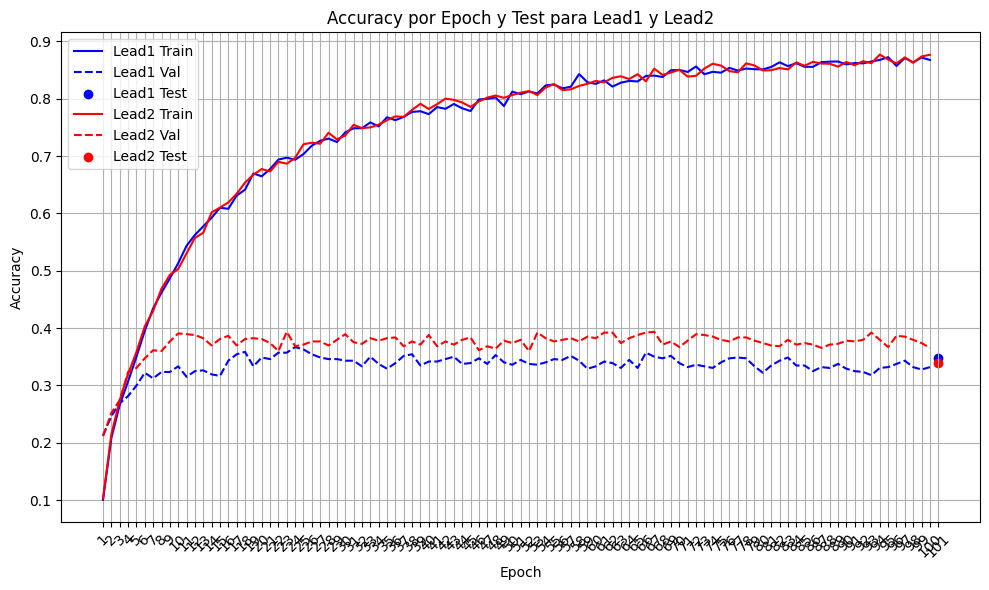

In [40]:
train_acc1 = history.history['lead1_accuracy']
val_acc1 = history.history['val_lead1_accuracy']
train_acc2 = history.history['lead2_accuracy']
val_acc2 = history.history['val_lead2_accuracy']
results = model.evaluate(X_test, Y_test, verbose=1)
test_acc1 = results[3]
test_acc2 = results[4]

import matplotlib.pyplot as plt

epochs = range(1, len(train_acc1) + 1)

plt.figure(figsize=(10,6))

# Lead 1
plt.plot(epochs, train_acc1, 'b-', label='Lead1 Train')
plt.plot(epochs, val_acc1, 'b--', label='Lead1 Val')
plt.scatter(len(epochs)+1, test_acc1, color='b', marker='o', label='Lead1 Test')

# Lead 2
plt.plot(epochs, train_acc2, 'r-', label='Lead2 Train')
plt.plot(epochs, val_acc2, 'r--', label='Lead2 Val')
plt.scatter(len(epochs)+1, test_acc2, color='r', marker='o', label='Lead2 Test')

plt.title('Accuracy por Epoch y Test para Lead1 y Lead2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(epochs) + [len(epochs)+1], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [41]:
print("Train accuracy lead1", train_acc1[-1])
print("Val accuracy lead1", val_acc1[-1])
print("Test accuracy lead1", test_acc1)
print()
print("Train accuracy lead2", train_acc2[-1])
print("Val accuracy lead2", val_acc2[-1])
print("Test accuracy lead2", test_acc2)

Train accuracy lead1 0.8676470518112183
Val accuracy lead1 0.33193278312683105
Test accuracy lead1 0.3482517600059509

Train accuracy lead2 0.8766506314277649
Val accuracy lead2 0.36554622650146484
Test accuracy lead2 0.33986014127731323


# Modelo 2.2

In [83]:
df3 = pd.read_csv(DRIVE_PATH + "vgc_encoded_augmentation_train.csv")
df3_val = pd.read_csv(DRIVE_PATH + "vgc_encoded_augmentation_val.csv")
df3_test = pd.read_csv(DRIVE_PATH + "vgc_encoded_augmentation_test.csv")

LABEL_COLS = ["j2_l1","j2_l2"]
INPUT_COLS = df3.columns.drop(LABEL_COLS).tolist()

X_train = df3[INPUT_COLS].to_numpy()
X_val = df3_val[INPUT_COLS].to_numpy()
X_test = df3_test[INPUT_COLS].to_numpy()

Y_train = df3[LABEL_COLS].to_numpy()
Y_val = df3_val[LABEL_COLS].to_numpy()
Y_test = df3_test[LABEL_COLS].to_numpy()

Y_train = [Y_train[:,0], Y_train[:,1]]
Y_val = [Y_val[:,0], Y_val[:,1]]
Y_test = [Y_test[:,0], Y_test[:,1]]

print(X_train.shape)


(23324, 86)


In [90]:
VOCABULARY = np.max(X) + 1
EMBEDDING_DIM = 64
SEQUENCE_LEN = len(INPUT_COLS)

inputs = layers.Input(shape=(SEQUENCE_LEN,))
embedding_layer = layers.Embedding(input_dim=VOCABULARY, output_dim=EMBEDDING_DIM)
result = embedding_layer(inputs)

flatten_layer = layers.Flatten()
result = flatten_layer(result)

result = layers.Dense(64, activation="relu")(result)
result = layers.Dense(64, activation="relu")(result)
result = layers.Dense(64, activation="relu")(result)
result = layers.Dense(64, activation="relu")(result)
result = layers.Dropout(0.5)(result)



softmax_layer1 = layers.Dense(VOCABULARY, activation="softmax", name="lead1")
softmax_layer2 = layers.Dense(VOCABULARY, activation="softmax", name="lead2")
output1 = softmax_layer1(result)
output2 = softmax_layer2(result)

model = Model(inputs=inputs, outputs=[output1,output2])

model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy", "accuracy"])

history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=100, verbose=0)
print("Entrenamiento listo")

Entrenamiento listo


23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - lead1_accuracy: 0.3310 - lead1_loss: 17.5885 - lead2_accuracy: 0.2976 - lead2_loss: 19.8144 - loss: 37.4209


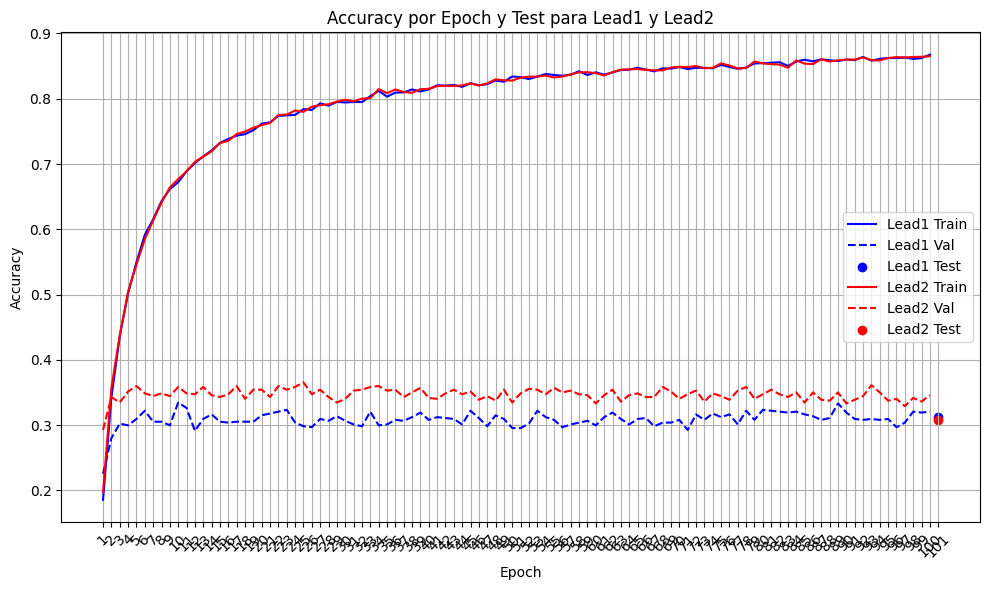

In [91]:
train_acc1 = history.history['lead1_accuracy']
val_acc1 = history.history['val_lead1_accuracy']
train_acc2 = history.history['lead2_accuracy']
val_acc2 = history.history['val_lead2_accuracy']
results = model.evaluate(X_test, Y_test, verbose=1)
test_acc1 = results[3]
test_acc2 = results[4]

import matplotlib.pyplot as plt

epochs = range(1, len(train_acc1) + 1)

plt.figure(figsize=(10,6))

# Lead 1
plt.plot(epochs, train_acc1, 'b-', label='Lead1 Train')
plt.plot(epochs, val_acc1, 'b--', label='Lead1 Val')
plt.scatter(len(epochs)+1, test_acc1, color='b', marker='o', label='Lead1 Test')

# Lead 2
plt.plot(epochs, train_acc2, 'r-', label='Lead2 Train')
plt.plot(epochs, val_acc2, 'r--', label='Lead2 Val')
plt.scatter(len(epochs)+1, test_acc2, color='r', marker='o', label='Lead2 Test')

plt.title('Accuracy por Epoch y Test para Lead1 y Lead2')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.xticks(list(epochs) + [len(epochs)+1], rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [92]:
print("Train accuracy lead1", train_acc1[-1])
print("Val accuracy lead1", val_acc1[-1])
print("Test accuracy lead1", test_acc1)
print()
print("Train accuracy lead2", train_acc2[-1])
print("Val accuracy lead2", val_acc2[-1])
print("Test accuracy lead2", test_acc2)

Train accuracy lead1 0.8675612807273865
Val accuracy lead1 0.3207283020019531
Test accuracy lead1 0.3132867217063904

Train accuracy lead2 0.8651174902915955
Val accuracy lead2 0.34593838453292847
Test accuracy lead2 0.3076923191547394
